![](./resources/System_v1_custom_croptype.png)

### Introduction

This notebook guides you through the process of training a custom crop type classification model using publicly available and harmonized in-situ reference data for your area and crop types of interest. Afterwards, the model can be applied to your season of interest to generate a crop type map.

### Content
  
- [Before you start](###-Before-you-start)
- [1. Define your region of interest](#1.-Define-your-region-of-interest)
- [2. Define your temporal extent](#2.-Define-your-temporal-extent)
- [3. Extract public reference data](#3-extract-public-reference-data)
- [4. Select your desired crop types](#4.-Select-your-desired-crop-types)
- [5. Prepare training features](#5.-Prepare-training-features)
- [6. Train custom classification model](#6.-Train-custom-classification-model)
- [7. Deploy your custom model](#7.-Deploy-your-custom-model)
- [8. Generate a map](#8.-Generate-a-map)


### Before you start

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/).
This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

### 1. Define your region of interest

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
The widget will automatically store the coordinates of the last rectangle you drew on the map.

<div class="alert alert-block alert-warning">
<b>Processing area limitation:</b><br> 
Processing areas beyond 2500 km² are currently not supported to avoid excessive credit usage and long processing times.<br>
Upon exceeding this limit, an error will be shown, and you will need to draw a new rectangle.

For testing purposes, we recommend you to select a small area (< 250 km²) in order to limit processing time and credit usage.

A run of 250 km² will typically consume 40 credits and last around 20 mins.<br>
A run of 750 km² will typically consume 90 credits and last around 50 mins.<br>
A run of 2500 km² will typically consume 250 credits and last around 1h 40 mins.
</div>

In [1]:
from worldcereal.utils.map import ui_map

map = ui_map(area_limit=2500)
map.show_map()

### 2. Define your temporal extent

To determine your season of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

2025-03-14 12:56:00.836 | INFO     | worldcereal.utils.map:get_extent:170 - Your extent: (4.890396, 51.221335, 4.982383, 51.267758)


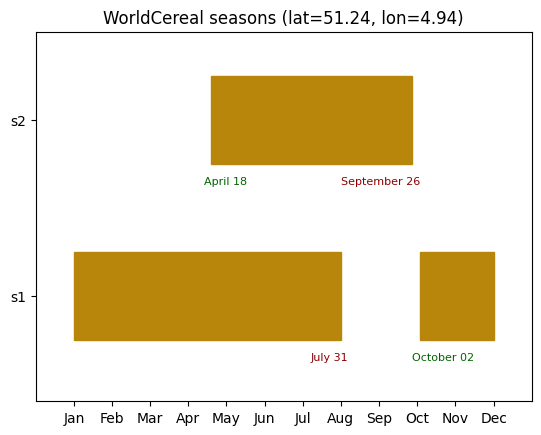

In [2]:
from notebook_utils.seasons import retrieve_worldcereal_seasons

spatial_extent = map.get_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now use the slider to select your processing period. Note that the length of the period is always fixed to a year.
Just make sure your season of interest is fully captured within the period you select.

In [3]:
from notebook_utils.dateslider import date_slider

slider = date_slider()

### 3. Extract public reference data

Here we query existing public reference data that have already been processed by WorldCereal and are ready to use.
To increase the number of hits, we expand the search area by 250 km in all directions.

We print the number of training samples retrieved per year.

To give you an idea on the regions where public crop type training data is available, consult the figure below:

<p align="center">
<img src="./resources/croptype_data_Ph1.png" alt="crop-data" width="400"/>
</p>

<div class="alert alert-block alert-warning">
<b>What to do in case no samples were found?</b><br> 

1. **Increase the buffer size**: Try increasing the buffer size by passing the `buffer` parameter to the `query_public_extractions` function (to a reasonable extent).
    *Current setting is: 250000 m².*
2. **Pick another area**
3. **Contribute data**: Collect some data and contribute to our global database! 🌍🌾 [Learn how to contribute here.](https://worldcereal.github.io/worldcereal-documentation/rdm/upload.html)

</div>

In [4]:
from worldcereal.utils.refdata import query_public_extractions

# Retrieve the polygon you just drew
polygon = map.get_polygon_latlon()

# Retrieve the date range you just selected
processing_period = slider.get_processing_period()

# Query our public database of training data
public_df = query_public_extractions(
    polygon, processing_period=processing_period, buffer=250000
)
public_df.year.value_counts()

2025-03-14 12:56:03.814 | INFO     | worldcereal.utils.map:get_extent:170 - Your extent: (4.890396, 51.221335, 4.982383, 51.267758)
2025-03-14 12:56:03.815 | INFO     | notebook_utils.dateslider:get_processing_period:187 - Selected processing period: 2018-01-01 to 2018-12-31
2025-03-14 12:56:03.816 | INFO     | worldcereal.utils.refdata:query_public_extractions:66 - Applying a buffer of 250 km to the selected area ...
2025-03-14 12:56:04.668 | INFO     | worldcereal.utils.refdata:query_public_extractions:102 - Found 10 datasets in WorldCereal global extractions database that intersect with the selected area.
2025-03-14 12:56:04.669 | INFO     | worldcereal.utils.refdata:query_public_extractions:107 - Querying WorldCereal global extractions database (this can take a while) ...
2025-03-14 12:56:30.318 | INFO     | worldcereal.utils.refdata:process_extractions_df:334 - Processing selected samples ...
2025-03-14 12:56:30.510 | INFO     | worldcereal.utils.refdata:process_extractions_df:358

year
2018    13247
2019     8382
2017     8366
2021     7946
2020      186
Name: count, dtype: int64

In [5]:
import glob

private_collection_paths = glob.glob(
    "/home/vito/butskoc/worldcereal-classification/notebooks/extractions/merged.geoparquet/**/*.parquet",
    recursive=True,
)
private_collection_paths

['/home/vito/butskoc/worldcereal-classification/notebooks/extractions/merged.geoparquet/ref_id=2018_ssd_wfpfieldsurvey_poly_110/data_0.parquet']

In [6]:
from worldcereal.utils.refdata import query_private_extractions

private_df = query_private_extractions(
    private_collection_paths, processing_period=processing_period
)
private_df.year.value_counts()

2025-03-14 12:56:58.975 | INFO     | worldcereal.utils.refdata:process_extractions_df:334 - Processing selected samples ...
2025-03-14 12:56:58.986 | INFO     | worldcereal.utils.refdata:process_extractions_df:358 - Aligning the samples with the user-defined temporal extent ...
2025-03-14 12:56:59.017 | WARNING  | worldcereal.utils.refdata:process_extractions_df:418 - Removed 0 samples that do not fit into selected temporal extent.
2025-03-14 12:56:59.024 | INFO     | worldcereal.utils.timeseries:check_median_distance:177 - Expected observations frequency: month; Median observed distance between observations: [30] days
2025-03-14 12:56:59.027 | WARNING  | worldcereal.utils.timeseries:check_feature_columns:423 - The following features are missing and are filled with NODATAVALUE: ['OPTICAL-B8A', 'METEO-precipitation_flux', 'METEO-temperature_mean']
2025-03-14 12:56:59.050 | INFO     | worldcereal.utils.timeseries:fill_missing_dates:262 - All samples have the expected number of observatio

year
2018    540
Name: count, dtype: int64

In [ ]:
import pandas as pd

merged_df = pd.merge(
    private_df,
    public_df,
    how="outer",
)
merged_df.shape

/tmp/ipykernel_2938886/4214360976.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_df = pd.merge(


(38667, 316)

### 4. Select your desired crop types

Run the next cell and select all crop types you wish to include in your model. All the crops that are not selected will be grouped under the "other" category.

In [11]:
from notebook_utils.classifier import pick_croptypes
from IPython.display import display

checkbox, checkbox_widgets, updated_class_map = pick_croptypes(
    merged_df, samples_threshold=100
)
display(checkbox)

Based on your selection, a custom target label is now generated for each sample. Verify that only crops of your choice are appearing in the `downstream_class`, all others will fall under `other`.

In [ ]:
from notebook_utils.classifier import get_custom_croptype_labels

public_df = get_custom_croptype_labels(public_df, checkbox_widgets, updated_class_map)
public_df["downstream_class"].value_counts()

### 5. Prepare training features

Using a deep learning framework (Presto), we derive classification features for each sample in the dataframe resulting from your query. Presto was pre-trained on millions of unlabeled samples around the world and finetuned on global labelled land cover and crop type data from the WorldCereal reference database. The resulting *embeddings* and the *target* labels to train on will be returned as a training dataframe which we will use for downstream model training.

In [ ]:
from notebook_utils.classifier import prepare_training_dataframe

training_dataframe = prepare_training_dataframe(public_df, task_type="croptype")
training_dataframe.head()

### 6. Train custom classification model
We train a catboost model for the selected crop types. By default, no class weighting is done. You could opt to enable this by setting `balance_classes=True`, however, depending on the class distribution this may lead to undesired results. There is no golden rule here.

In [ ]:
from notebook_utils.classifier import train_classifier

custom_model, report, confusion_matrix = train_classifier(
    training_dataframe, balance_classes=False
)

Before training, the available training data has been automatically split into a calibration and validation part. By executing the next cell, you get an idea of how well the model performs on the independent validation set.

In [ ]:
# Print the classification report
print(report)

### 7. Deploy your custom model

Once trained, we have to upload our model to the cloud so it can be used by OpenEO for inference. Note that these models are only kept in cloud storage for a limited amount of time.


In [ ]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection
from utils import get_input

modelname = get_input("model")
model_url = deploy_model(cdse_connection(), custom_model, pattern=modelname)
print(f"Your model can be downloaded from: {model_url}")

### 8. Generate a map

Using our custom model, we generate a map for our region and season of interest.

Set some other customization options:

In [ ]:
from worldcereal.job import PostprocessParameters
import os
from pathlib import Path

# Choose whether you want to store the cropland mask as separate output file
save_mask = True

# Choose whether or not you want to spatially clean the classification results
postprocess_result = True
# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"]
# ("smooth_probabilities will do limited spatial cleaning,
# while "majority_vote" will do more aggressive spatial cleaning, depending on the value of kernel_size)
postprocess_method = "majority_vote"
# Additional parameter for the majority vote method
# (the higher the value, the more aggressive the spatial cleaning,
# should be an odd number, not larger than 25, default = 5)
kernel_size = 5
# Do you want to save the intermediate results (before applying the postprocessing)
save_intermediate = True
# Do you want to save all class probabilities in the final product? (default is False)
keep_class_probs = True

postprocess_parameters = PostprocessParameters(
    enable=postprocess_result,
    method=postprocess_method,
    kernel_size=kernel_size,
    save_intermediate=save_intermediate,
    keep_class_probs=keep_class_probs,
)

# The output directory is named after the model
output_dir = Path(os.getcwd()) / f"CROPTYPE_{modelname}"
print(f"Output directory: {output_dir}")

We now have all information we need to generate our map!<br>
The next cell will submit a map inference job on CDSE through OpenEO.<br>
The first time you run this, you will be asked to authenticate with your CDSE account by clicking the link provided below the cell.<br>
Then sit back and wait untill your map is ready...

In [ ]:
from worldcereal.job import WorldCerealProductType, generate_map, CropTypeParameters

# Initializes default parameters
parameters = CropTypeParameters()

# Change the URL to your custom classification model
parameters.classifier_parameters.classifier_url = model_url
parameters.save_mask = save_mask

# Get processing period and area
processing_period = slider.get_processing_period()
processing_extent = map.get_extent()

# Launch the job
job_results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    product_type=WorldCerealProductType.CROPTYPE,
    croptype_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
)

In [ ]:
# The results contain the openeo job id...
print(f"Job id: {job_results.job_id}")
print(f"Location of metadata: {job_results.metadata}")
# ... a list of products that were downloaded...
print(f"Products: {job_results.products.keys()}")
# ... for each product:
print("-- For each product --")
print(f"Type: {job_results.products['croptype']['type']}")
print(f"Temporal extent: {job_results.products['croptype']['temporal_extent']}")
print(f"Look-up table: {job_results.products['croptype']['lut']}")
print(f"URL: {job_results.products['croptype']['url']}")
print(f"Local path: {job_results.products['croptype']['path']}")

The classification results will be automatically downloaded to your *output_dir* in .tif format.

For a model with two classes, you get a raster file containing up to four bands:
1. The label of the winning class
2. The probability of the winning class [0 - 100]
3. and beyond (optional, depending on settings): Class probabilities of each class, ordered according to the look-up table. The look-up table for each product can be consulted in the 'results' object as produced by the 'generate_map' function.

Using the function below, we split this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "croptype_classification_start-date_end-date.tif" --> contains the classification labels. A class look-up table is included in the .tif metadata.
- "croptype_probability_start-date_end-date.tif" -->  contains the probability associated with the prediction [0 - 100]

In case you chose to store the original per-class probabilities, these are NOT written to a separate file and need to be consulted in the original result downloaded from OpenEO.

Note that in case you chose to apply post-processing AND save intermediate results, you will also get a "croptype-raw_xxx.tif" output, which holds the classification labels and probabilities BEFORE post-processing.

Also note that if you chose to save the cropland mask as a separate output, you will also get a cropland (and potentially cropland-raw) product.

In [ ]:
from notebook_utils.visualization import prepare_visualization

filepaths = prepare_visualization(job_results)
print(filepaths)

In [ ]:
from notebook_utils.visualization import visualize_classification

visualize_classification(filepaths, "croptype")

The resulting raster files can be visualized in QGIS.

<div class="alert alert-block alert-danger">
<b>WARNING:</b> <br>
In case you run this notebook through the Terrascope environment, ALWAYS make sure you download the resulting files to your local system!<br>
The Terrascope environment will be cleaned automatically upon exit!
</div>

In case you are running this script on your local environment, you can alternatively use the following cells to visualize the outputs directly in this notebook.

In [ ]:
from notebook_utils.visualization import visualize_products

visualize_products(filepaths, port=8887)

In [ ]:
from notebook_utils.visualization import show_color_legend

show_color_legend(filepaths, "croptype")